In [1]:
# 라이브러리 호출

%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import numpy as np

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann

In [4]:
# gt file과 raw image file path를 이용해 데이터를 불러온다.
# train.json 파일 경로를 사용하도록 수정 필요.
# colab을 활용할 경우 train.json 파일을 google drive에서 불러오도록 수정 필요.
path_lists = glob.glob(f"./code/data/*_receipt/ufo/train.json")

# 각 json 파일을 읽어서 하나로 합친다.
data = {}
data['images'] = {}
for path in path_lists:
    json_data = read_json(path)
    # 각 파일에서 100개의 이미지 씩만 확인합니다.
    images = list(json_data['images'].items())[:100]
    data['images'].update(dict(images))

print(f"Total number of images: {len(data['images'])}")


Total number of images: 400


In [5]:
print(data.keys())
print(len(data['images'].keys()))
print(data['images']["extractor.zh.in_house.appen_000692_page0001.jpg"].keys())

for a in data['images']["extractor.zh.in_house.appen_000692_page0001.jpg"].keys():
    print(a)

dict_keys(['images'])
400
dict_keys(['paragraphs', 'words', 'chars', 'img_w', 'img_h', 'num_patches', 'tags', 'relations', 'annotation_log', 'license_tag'])
paragraphs
words
chars
img_w
img_h
num_patches
tags
relations
annotation_log
license_tag


이미지의 가로, 세로에 대한 분포

<Figure size 1400x600 with 0 Axes>

<Axes: >

<Axes: ylabel='Count'>

Text(0.5, 0, 'Image Width (pixels)')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of Image Width')

<Axes: >

<Axes: ylabel='Count'>

Text(0.5, 0, 'Image Height (pixels)')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of Image Height')

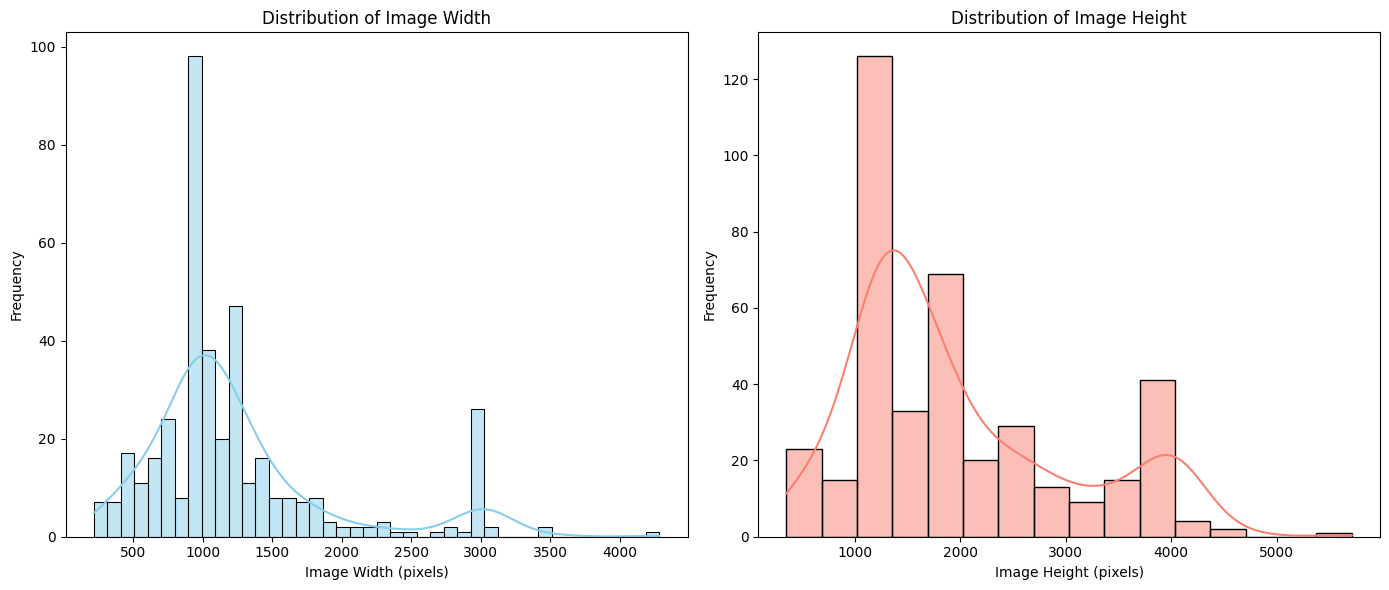

In [6]:
# 이미지의 너비와 높이를 리스트로 정리
img_widths = [img['img_w'] for img in data['images'].values()]
img_heights = [img['img_h'] for img in data['images'].values()]

# 히스토그램 시각화
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(img_widths, kde=True, color='skyblue')
plt.xlabel("Image Width (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of Image Width")

plt.subplot(1, 2, 2)
sns.histplot(img_heights, kde=True, color='salmon')
plt.xlabel("Image Height (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of Image Height")

plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Image Width (pixels)')

Text(0, 0.5, 'Image Height (pixels)')

Text(0.5, 1.0, 'Scatter Plot of Image Width vs. Height')

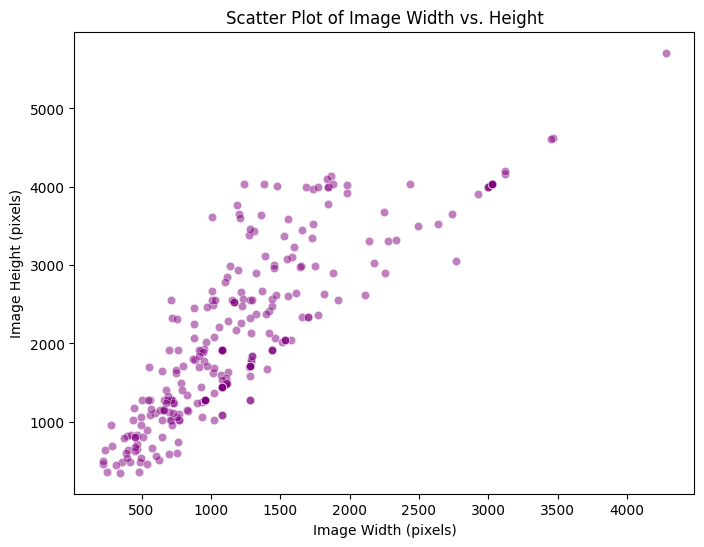

In [7]:
# 너비와 높이 산포도
plt.figure(figsize=(8, 6))
sns.scatterplot(x=img_widths, y=img_heights, color="purple", alpha=0.5)
plt.xlabel("Image Width (pixels)")
plt.ylabel("Image Height (pixels)")
plt.title("Scatter Plot of Image Width vs. Height")
plt.show()


<Figure size 800x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 0, 'Aspect Ratio (Width / Height)')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Distribution of Image Aspect Ratios')

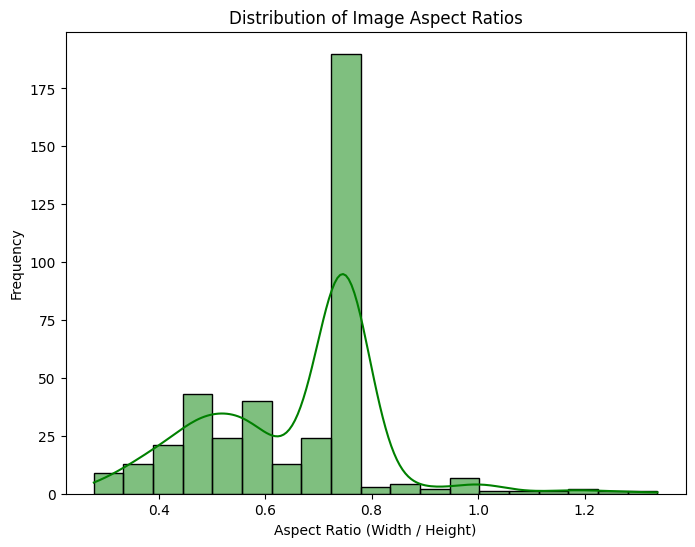

In [8]:
# 가로세로 비율 계산
aspect_ratios = [w / h if h != 0 else 0 for w, h in zip(img_widths, img_heights)]

# 가로세로 비율 분포
plt.figure(figsize=(8, 6))
sns.histplot(aspect_ratios, kde=True, color='green')
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.title("Distribution of Image Aspect Ratios")
plt.show()


box의 개수

In [9]:
sum = 0
for image_key, image_value in data['images'].items():
    sum += len(image_value['words'].items())

print(f'box 총 개수 {sum}')
        

box 총 개수 31162


언어에 따라서 학습하기 힘들어할까?

각도 EDA

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 주어진 점들
points = np.array([
    # [309.567218, 349.305754],
    # [619.610845, 370.931142],
    # [615.564733, 414.860354],
    # [301.70207, 392.895748]
    [0, 1],
    [3, 4],
    [4, 3],
    [1, 0]
    
])

# 두 점 간 거리 계산 함수
def distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def angle(points):
    # 모든 변의 길이 계산
    lengths = []
    lengths.append((distance(points[0], points[1]), 0, 1))
    lengths.append((distance(points[0], points[3]), 0, 3))

    # 가장 긴 변 찾기
    longest_edge = max(lengths)
    point1, point2 = points[longest_edge[1]], points[longest_edge[2]]

    # 긴 변의 기울기 계산
    delta_x = point2[0] - point1[0]
    delta_y = point2[1] - point1[1]
    angle_rad = np.arctan2(delta_y, delta_x)  # 수평선과의 각도 (라디안)
    angle_deg = np.degrees(angle_rad)  # 각도를 도로 변환

    return angle_rad, angle_deg # 라디안, 도? 반환

# 결과 출력
angles = angle(points)[1]
print(f'수평과의 각도: {angle(points)[1]:.2f}도')



수평과의 각도: 45.00도


In [11]:
angles = []
# 각 이미지에 대해 단어의 가로 세로를 계산
for image_key, image_value in data['images'].items():
    for word_key, word_info in image_value['words'].items():
        angle_deg = angle(np.array(word_info['points']))[1]
        angles.append(angle_deg)
        
# # EDA: 각도 분포 시각화
# plt.figure(figsize=(10, 6))
# sns.histplot(angles, bins=30, kde=True)
# plt.title('Angle Distribution of Words')
# plt.xlabel('Angle (degrees)')
# plt.ylabel('Frequency')
# plt.axvline(np.mean(angles), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(angles):.2f}')
# plt.axvline(np.median(angles), color='blue', linestyle='dashed', linewidth=1, label=f'Median: {np.median(angles):.2f}')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# EDA: 각도 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(angles, bins=30, kde=True)  # 히스토그램과 KDE
plt.title('Angle Distribution of Words')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')

# 평균과 중앙값을 추가
mean_angle = np.mean(angles)
median_angle = np.median(angles)

plt.axvline(mean_angle, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_angle:.2f}')
plt.axvline(median_angle, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {median_angle:.2f}')
plt.legend()
plt.grid()
plt.show()

<Figure size 1000x600 with 0 Axes>